# Music Classification Training with Audio Augmentation

This notebook demonstrates training a contrastive learning model on music audio using a **two-stage augmentation pipeline**:

## Two-Stage Augmentation Pipeline

### Stage 1: Waveform Augmentations (Before Mel Spectrogram)
- Pitch shift (±1-3 semitones)
- Tempo stretch (±5-12%)
- Gain adjustment (±3-6 dB)
- Parametric EQ filtering
- Dynamic range compression
- Environmental noise (SNR 10-30 dB)
- Convolutional reverb

### Stage 2: Spectrogram Augmentations (After Mel Transform)
- Time masking (SpecAugment)
- Frequency masking (SpecAugment)
- Time warping

## Dataset Structure

The `fma_small_dataset` contains **8000 audio files directly in one folder** (flat structure):
```
AudioToSpectogram/
  fma_small_dataset/
    000002.mp3
    000005.mp3
    ... (8000 files total)
```

This notebook will automatically split the data into 80% train / 20% validation.

## 1. Setup Environment

In [1]:
# Check GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

PyTorch version: 2.3.1+cu121
CUDA available: True
CUDA version: 12.1
GPU: NVIDIA RTX A6000
GPU Memory: 51.04 GB


In [2]:
# Setup working directory
import os
from pathlib import Path

# Get notebook directory
notebook_dir = Path.cwd()
project_root = notebook_dir.parent if notebook_dir.name == 'notebooks' else notebook_dir

# Change to project root
os.chdir(project_root)
print(f"✓ Working directory: {project_root}")
print(f"✓ Project root: {project_root.name}")

✓ Working directory: /DATA/LLMM/Music-Classification-by-Spectogram
✓ Project root: Music-Classification-by-Spectogram


## 2. Install Dependencies

In [3]:
# Install dependencies
!pip install -q -r requirements.txt
print("✓ Dependencies installed")

✓ Dependencies installed


## 3. Verify Audio Dataset

In [4]:
# Verify Audio Dataset
from pathlib import Path

# Check if audio dataset exists
audio_dataset_path = Path('/DATA/LLMM/Music-Classification-by-Spectogram/AudioToSpectogram/fma_small_dataset')

if audio_dataset_path.exists():
    # Count audio files
    audio_files = list(audio_dataset_path.glob('*.mp3'))
    audio_files.extend(list(audio_dataset_path.glob('*.wav')))
    audio_files.extend(list(audio_dataset_path.glob('*.flac')))
    
    print(f"✓ Audio dataset found: {audio_dataset_path}")
    print(f"✓ Total audio files: {len(audio_files)}")
    print(f"\nFirst 5 files:")
    for i, f in enumerate(audio_files[:5]):
        print(f"  {i+1}. {f.name}")
    
    # Dataset will be automatically split 80/20 during training
    train_count = int(len(audio_files) * 0.8)
    val_count = len(audio_files) - train_count
    print(f"\nAutomatic split (80/20):")
    print(f"  Training: {train_count} files (80%)")
    print(f"  Validation: {val_count} files (20%)")
else:
    print(f"❌ Audio dataset not found: {audio_dataset_path}")
    print("\nPlease ensure the fma_small_dataset is available at:")
    print("  AudioToSpectogram/fma_small_dataset/")
    print("  (All audio files should be directly in this folder)")

✓ Audio dataset found: /DATA/LLMM/Music-Classification-by-Spectogram/AudioToSpectogram/fma_small_dataset
✓ Total audio files: 8000

First 5 files:
  1. 149417.mp3
  2. 117160.mp3
  3. 117609.mp3
  4. 126505.mp3
  5. 003265.mp3

Automatic split (80/20):
  Training: 6400 files (80%)
  Validation: 1600 files (20%)


## 4. Load Configuration Files

In [5]:
# Load configuration files
import yaml
from pathlib import Path

def load_config(config_path):
    """Load YAML configuration file"""
    with open(config_path, 'r') as f:
        return yaml.safe_load(f)

# Load all configs
model_config = load_config('/DATA/LLMM/Music-Classification-by-Spectogram/configs/model_config.yaml')
training_config = load_config('/DATA/LLMM/Music-Classification-by-Spectogram/configs/training_config.yaml')
data_config = load_config('/DATA/LLMM/Music-Classification-by-Spectogram/configs/data_config.yaml')

# Try to load audio augmentation config (new)
try:
    audio_aug_config = load_config('/DATA/LLMM/Music-Classification-by-Spectogram/configs/audio_augmentation_config.yaml')
    print("✓ Audio augmentation config loaded")
    use_audio_aug = True
except FileNotFoundError:
    print("⚠ Audio augmentation config not found, using default settings")
    audio_aug_config = {}
    use_audio_aug = False

# Merge configs
config = {**model_config, **training_config, **data_config}
if audio_aug_config:
    config['audio_augmentation'] = audio_aug_config

print("\nConfiguration loaded successfully!")
print(f"\nModel: {config['model']['name']}")
print(f"Embedding dimension: {config['model']['projection_head']['embedding_dim']}")
print(f"Batch size: {config['training']['batch_size']}")
print(f"Epochs: {config['training']['epochs']}")
print(f"Learning rate: {config['training']['optimizer']['learning_rate']}")
print(f"Audio augmentation: {'Enabled' if use_audio_aug else 'Disabled'}")

✓ Audio augmentation config loaded

Configuration loaded successfully!

Model: AudioEncoderCNN
Embedding dimension: 256
Batch size: 64
Epochs: 200
Learning rate: 0.001
Audio augmentation: Enabled


In [6]:
# Update data paths for audio dataset
config['data']['audio_dir'] = '/DATA/LLMM/Music-Classification-by-Spectogram/AudioToSpectogram/fma_small_dataset'
config['data']['train_val_split'] = 0.8  # 80% train, 20% validation

# Adjust batch size for GPU memory (reduce if OOM errors occur)
config['training']['batch_size'] = 64

# Adjust number of workers
config['training']['num_workers'] = 15

# Audio augmentation settings
if 'audio_augmentation' in config:
    # Use audio augmentation config
    config['use_audio_augmentation'] = True
    print("Using audio augmentation pipeline (waveform + spectrogram)")
else:
    # Fall back to traditional spectrogram augmentation
    config['use_audio_augmentation'] = False
    print("Using traditional spectrogram-only augmentation")

print(f"\nConfiguration updated:")
print(f"  Audio directory: {config['data']['audio_dir']}")
print(f"  Train/Val split: {config['data']['train_val_split']:.0%}")
print(f"  Batch size: {config['training']['batch_size']}")
print(f"  Num workers: {config['training']['num_workers']}")

Using audio augmentation pipeline (waveform + spectrogram)

Configuration updated:
  Audio directory: /DATA/LLMM/Music-Classification-by-Spectogram/AudioToSpectogram/fma_small_dataset
  Train/Val split: 80%
  Batch size: 64
  Num workers: 15


## 4.1 Audio Augmentation Strategy

### Waveform Augmentations (Stage 1 - Before Mel Transform)
Applied to raw audio with configurable probabilities:

In [7]:
# Import model components
import sys
sys.path.append('CNN')

from CNN.models import build_model
from CNN.augmentation import get_augmentation_pipeline
from CNN.data import create_dataloaders
from CNN.training import get_contrastive_loss
from CNN.utils.metrics import AverageMeter

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Build model
print("\nBuilding model...")
model = build_model(config)
model = model.to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Summary:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / 1e6:.2f} MB (float32)")

Using device: cuda

Building model...

Model Summary:
Total parameters: 1,946,752
Trainable parameters: 1,946,752
Model size: 7.79 MB (float32)


## 6. Data Loading with Augmentation

In [8]:
# Create data loaders with audio augmentation
import sys
sys.path.append('../CNN')

if config.get('use_audio_augmentation', False):
    # Use new audio augmentation pipeline
    from CNN.augmentation.audio_augmentations import (
        ContrastiveAudioAugmentation,
        AudioDatasetWithAugmentation
    )
    from torch.utils.data import DataLoader, Subset
    from sklearn.model_selection import train_test_split
    
    print("Setting up audio augmentation pipeline...")
    
    # Get audio augmentation config or use defaults
    if 'audio_augmentation' in config:
        aug_config = config['audio_augmentation']['augmentation']['audio']
        aug_pipeline = ContrastiveAudioAugmentation(
            sr=aug_config.get('sample_rate', 22050),
            n_fft=aug_config.get('n_fft', 2048),
            hop_length=aug_config.get('hop_length', 512),
            n_mels=aug_config.get('n_mels', 128),
            duration=aug_config.get('duration', 3.0),
            num_waveform_augs=aug_config.get('num_waveform_augs', 4),
            num_spectrogram_augs=aug_config.get('num_spectrogram_augs', 2),
            max_workers=aug_config.get('max_workers', 10),
            waveform_aug_probs=aug_config.get('waveform_probs'),
            spectrogram_aug_probs=aug_config.get('spectrogram_probs')
        )
    else:
        # Use default settings
        aug_pipeline = ContrastiveAudioAugmentation(
            sr=22050,
            n_mels=128,
            duration=3.0,
            num_waveform_augs=3,
            num_spectrogram_augs=2,
            max_workers=15
        )
    
    print("✓ Audio augmentation pipeline initialized")
    
    # Create full dataset
    full_dataset = AudioDatasetWithAugmentation(
        audio_dir=config['data']['audio_dir'],
        augmentation=aug_pipeline,
        file_extensions=('.wav', '.mp3', '.flac', '.ogg', '.m4a')
    )
    
    print(f"✓ Full dataset created: {len(full_dataset)} audio files")
    
    # Split into train/val
    indices = list(range(len(full_dataset)))
    train_indices, val_indices = train_test_split(
        indices, 
        train_size=config['data']['train_val_split'],
        random_state=42
    )
    
    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)
    
    print(f"✓ Dataset split: {len(train_dataset)} train, {len(val_dataset)} val")
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['training']['batch_size'],
        shuffle=True,
        num_workers=config['training']['num_workers'],
        pin_memory=True,
        drop_last=True,
        persistent_workers=True if config['training']['num_workers'] > 0 else False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config['training']['batch_size'],
        shuffle=False,
        num_workers=config['training']['num_workers'],
        pin_memory=True,
        persistent_workers=True if config['training']['num_workers'] > 0 else False
    )
    
    print(f"✓ DataLoaders created:")
    print(f"  Train batches: {len(train_loader)}")
    print(f"  Val batches: {len(val_loader)}")
    
else:
    # Use traditional spectrogram augmentation
    from CNN.augmentation import get_augmentation_pipeline
    from CNN.data import create_dataloaders
    
    print("Using traditional spectrogram-only augmentation...")
    
    train_transform = get_augmentation_pipeline(config, training=True)
    val_transform = get_augmentation_pipeline(config, training=False)
    
    train_loader, val_loader = create_dataloaders(config, train_transform, val_transform)
    
    print(f"Train batches: {len(train_loader)}")
    print(f"Val batches: {len(val_loader)}")
    print(f"Train samples: {len(train_loader.dataset)}")
    print(f"Val samples: {len(val_loader.dataset)}")

Setting up audio augmentation pipeline...
✓ Audio augmentation pipeline initialized
Found 8000 audio files in /DATA/LLMM/Music-Classification-by-Spectogram/AudioToSpectogram/fma_small_dataset
✓ Full dataset created: 8000 audio files
✓ Dataset split: 6400 train, 1600 val
✓ DataLoaders created:
  Train batches: 100
  Val batches: 25


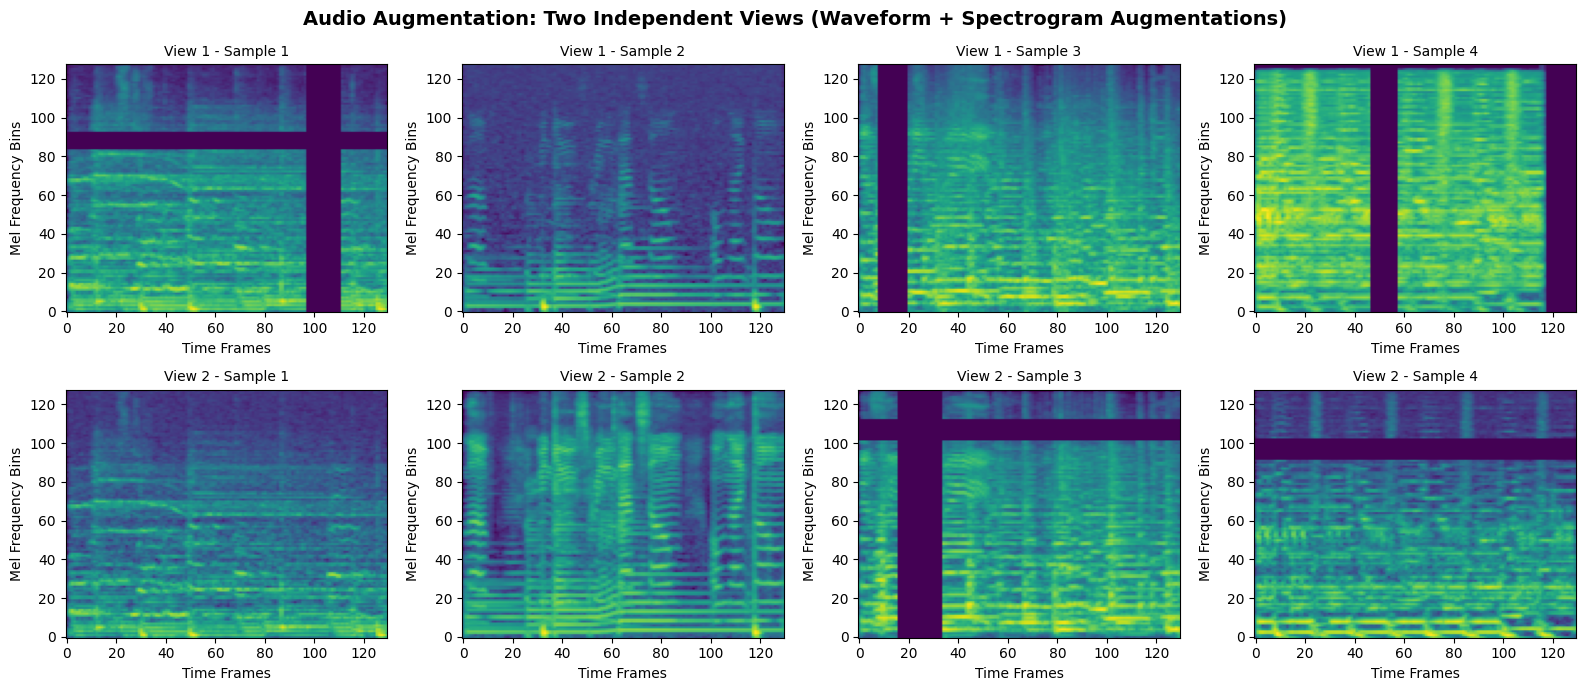


📊 Augmentation Details:
  - View 1: 3 random waveform augmentations + 2 random spectrogram augmentations
  - View 2: Independent 3 random waveform + 2 random spectrogram augmentations
  - Spectrogram shape: torch.Size([64, 1, 128, 130])
  - Format: [batch_size, channels, n_mels, time_steps]


In [9]:
# Visualize augmented spectrograms
import matplotlib.pyplot as plt
import numpy as np

def visualize_audio_augmentation(loader, num_samples=4):
    """
    Visualize augmented mel spectrogram pairs from audio
    """
    view1, view2 = next(iter(loader))
    
    fig, axes = plt.subplots(2, num_samples, figsize=(16, 7))
    fig.suptitle('Audio Augmentation: Two Independent Views (Waveform + Spectrogram Augmentations)', 
                 fontsize=14, fontweight='bold')
    
    for i in range(min(num_samples, view1.shape[0])):
        # View 1 - Remove channel dimension and transpose for display
        spec1 = view1[i].cpu().numpy()
        if len(spec1.shape) == 3:
            spec1 = spec1[0]  # Remove channel dimension [1, n_mels, time] -> [n_mels, time]
        
        # View 2
        spec2 = view2[i].cpu().numpy()
        if len(spec2.shape) == 3:
            spec2 = spec2[0]
        
        # Plot View 1
        im1 = axes[0, i].imshow(spec1, aspect='auto', origin='lower', cmap='viridis')
        axes[0, i].set_title(f'View 1 - Sample {i+1}', fontsize=10)
        axes[0, i].set_ylabel('Mel Frequency Bins')
        axes[0, i].set_xlabel('Time Frames')
        
        # Plot View 2
        im2 = axes[1, i].imshow(spec2, aspect='auto', origin='lower', cmap='viridis')
        axes[1, i].set_title(f'View 2 - Sample {i+1}', fontsize=10)
        axes[1, i].set_ylabel('Mel Frequency Bins')
        axes[1, i].set_xlabel('Time Frames')
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Augmentation Details:")
    print("  - View 1: 3 random waveform augmentations + 2 random spectrogram augmentations")
    print("  - View 2: Independent 3 random waveform + 2 random spectrogram augmentations")
    print(f"  - Spectrogram shape: {view1.shape}")
    print(f"  - Format: [batch_size, channels, n_mels, time_steps]")

try:
    visualize_audio_augmentation(train_loader, num_samples=4)
except Exception as e:
    print(f"Error during visualization: {e}")
    print("Trying with smaller sample size...")
    try:
        visualize_audio_augmentation(train_loader, num_samples=2)
    except Exception as e2:
        print(f"Visualization failed: {e2}")

## 7. Pre-Generate Augmented Spectrograms (Optional but Recommended)

This step will **pre-compute and save** augmented spectrograms to disk so you don't have to regenerate them every training run.

### Benefits:
- ✅ **Much faster training** - No augmentation overhead during training
- ✅ **Reusable** - Use the same augmented data across multiple experiments
- ✅ **Reproducible** - Fixed augmentations for consistent results
- ✅ **Efficient** - Generate once, use many times

### Options:
1. **Generate multiple augmented versions per audio** (recommended for contrastive learning)
2. **Save as PyTorch tensors** for fastest loading
3. **Save with metadata** for tracking

**Run the cells below to pre-generate augmented spectrograms.**

In [10]:
# Configuration for pre-generating augmented spectrograms
import os
from pathlib import Path

# Settings
PRE_GENERATE = True  # Set to True to pre-generate, False to skip
NUM_AUGMENTED_VERSIONS = 5  # Generate 5 augmented versions per audio file
OUTPUT_DIR = Path('../data/augmented_spectrograms')
TRAIN_OUTPUT_DIR = OUTPUT_DIR / 'train'
VAL_OUTPUT_DIR = OUTPUT_DIR / 'val'

# Create directories
TRAIN_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
VAL_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Check if already generated
existing_train_files = list(TRAIN_OUTPUT_DIR.glob('*.pt'))
existing_val_files = list(VAL_OUTPUT_DIR.glob('*.pt'))

if len(existing_train_files) > 0 and len(existing_val_files) > 0:
    print(f"✓ Pre-generated spectrograms already exist:")
    print(f"  Training: {len(existing_train_files)} files")
    print(f"  Validation: {len(existing_val_files)} files")
    print(f"\nTo regenerate, delete the directories and rerun this cell.")
    SKIP_GENERATION = True
else:
    print(f"Pre-generation settings:")
    print(f"  Output directory: {OUTPUT_DIR}")
    print(f"  Versions per audio: {NUM_AUGMENTED_VERSIONS}")
    print(f"  Expected train files: {len(train_indices) * NUM_AUGMENTED_VERSIONS}")
    print(f"  Expected val files: {len(val_indices) * NUM_AUGMENTED_VERSIONS}")
    print(f"\nTotal storage needed: ~{(len(train_indices) + len(val_indices)) * NUM_AUGMENTED_VERSIONS * 0.5:.1f} MB")
    SKIP_GENERATION = False

Pre-generation settings:
  Output directory: ../data/augmented_spectrograms
  Versions per audio: 5
  Expected train files: 32000
  Expected val files: 8000

Total storage needed: ~20000.0 MB


In [11]:
# Pre-generate augmented spectrograms
import torch
import json
from tqdm.auto import tqdm
import time

if PRE_GENERATE and not SKIP_GENERATION:
    print("=" * 60)
    print("PRE-GENERATING AUGMENTED SPECTROGRAMS")
    print("=" * 60)
    print("\nThis will take some time but only needs to be done once!")
    print("You can use these pre-generated spectrograms for faster training.\n")
    
    # Track metadata
    metadata = {
        'train': [],
        'val': [],
        'config': {
            'sample_rate': aug_pipeline.sr,
            'n_mels': aug_pipeline.n_mels,
            'duration': aug_pipeline.duration,
            'num_versions': NUM_AUGMENTED_VERSIONS,
            'num_waveform_augs': aug_pipeline.num_waveform_augs,
            'num_spectrogram_augs': aug_pipeline.num_spectrogram_augs,
        }
    }
    
    def generate_and_save(indices, output_dir, split_name):
        """Generate augmented spectrograms for a split"""
        print(f"\n{'='*60}")
        print(f"Generating {split_name.upper()} set")
        print(f"{'='*60}")
        
        total_files = len(indices) * NUM_AUGMENTED_VERSIONS
        pbar = tqdm(total=total_files, desc=f"{split_name.capitalize()}")
        
        split_metadata = []
        error_count = 0
        
        for idx in indices:
            try:
                # Get original audio path
                audio_path = str(full_dataset.audio_paths[idx])
                audio_name = Path(audio_path).stem
                
                # Generate multiple augmented versions
                for version in range(NUM_AUGMENTED_VERSIONS):
                    try:
                        # Generate augmented spectrogram pair
                        view1, view2 = full_dataset[idx]
                        
                        # Save both views
                        output_file = output_dir / f"{audio_name}_v{version}.pt"
                        torch.save({
                            'view1': view1,
                            'view2': view2,
                            'audio_name': audio_name,
                            'version': version,
                            'original_path': audio_path
                        }, output_file)
                        
                        # Track metadata
                        split_metadata.append({
                            'file': str(output_file),
                            'audio_name': audio_name,
                            'version': version,
                            'shape': list(view1.shape)
                        })
                        
                        pbar.update(1)
                        
                    except Exception as e:
                        error_count += 1
                        pbar.set_postfix({'errors': error_count})
                        continue
                        
            except Exception as e:
                error_count += NUM_AUGMENTED_VERSIONS
                pbar.set_postfix({'errors': error_count})
                continue
        
        pbar.close()
        
        print(f"✓ {split_name.capitalize()} complete: {len(split_metadata)} files generated")
        if error_count > 0:
            print(f"⚠ {error_count} files had errors and were skipped")
        
        return split_metadata
    
    # Generate training set
    start_time = time.time()
    metadata['train'] = generate_and_save(train_indices, TRAIN_OUTPUT_DIR, 'train')
    
    # Generate validation set
    metadata['val'] = generate_and_save(val_indices, VAL_OUTPUT_DIR, 'val')
    
    # Save metadata
    metadata_file = OUTPUT_DIR / 'metadata.json'
    with open(metadata_file, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    total_time = time.time() - start_time
    print(f"\n{'='*60}")
    print(f"GENERATION COMPLETE!")
    print(f"{'='*60}")
    print(f"Total time: {total_time/60:.1f} minutes")
    print(f"Total files generated: {len(metadata['train']) + len(metadata['val'])}")
    print(f"Metadata saved to: {metadata_file}")
    print(f"\nYou can now use these pre-generated spectrograms for fast training!")

elif SKIP_GENERATION:
    print("\n✓ Skipping generation - using existing files")
    print("Loading metadata...")
    metadata_file = OUTPUT_DIR / 'metadata.json'
    if metadata_file.exists():
        with open(metadata_file, 'r') as f:
            metadata = json.load(f)
        print(f"✓ Metadata loaded: {len(metadata['train'])} train, {len(metadata['val'])} val")
    else:
        print("⚠ No metadata file found")
else:
    print("\nPRE_GENERATE is set to False. Skipping pre-generation.")
    print("You will use on-the-fly augmentation during training.")

PRE-GENERATING AUGMENTED SPECTROGRAMS

This will take some time but only needs to be done once!
You can use these pre-generated spectrograms for faster training.


Generating TRAIN set


Train:   0%|          | 0/32000 [00:00<?, ?it/s]

[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
Note: Illegal Audio-MPEG-Header 0x00000000 at offset 22401.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Note: Illegal Audio-MPEG-Header 0x00000000 at offset 22401.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Note: Illegal Audio-MPEG-Header 0x00000000 at offset 22401.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Note: Illegal Audio-MPEG-Header 0x00000000 at offset 22401.
Note: Trying to resync...
Note: Skipped

✓ Train complete: 31995 files generated
⚠ 5 files had errors and were skipped

Generating VAL set


Val:   0%|          | 0/8000 [00:00<?, ?it/s]

[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...
[src/libmpg123/parse.c:do_readahead():1083] warning: Ca

✓ Val complete: 7990 files generated
⚠ 10 files had errors and were skipped

GENERATION COMPLETE!
Total time: 42.8 minutes
Total files generated: 39985
Metadata saved to: ../data/augmented_spectrograms/metadata.json

You can now use these pre-generated spectrograms for fast training!


In [12]:
# Custom Dataset for loading pre-generated spectrograms
import torch
from torch.utils.data import Dataset, DataLoader
import random
import torch.nn.functional as F

class PreGeneratedSpectrogramDataset(Dataset):
    """Dataset that loads pre-generated augmented spectrograms"""
    
    def __init__(self, metadata_list):
        """
        Args:
            metadata_list: List of metadata dicts with 'file' paths
        """
        self.files = [item['file'] for item in metadata_list]
        print(f"Initialized dataset with {len(self.files)} pre-generated files")
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        """
        Returns a pair of augmented views (view1, view2) from pre-generated file
        """
        try:
            # Load pre-generated file
            data = torch.load(self.files[idx], weights_only=False)
            
            # Create completely new tensors to avoid storage sharing issues
            # This ensures tensors can be safely batched in multi-worker DataLoaders
            view1 = data['view1'].clone().detach().float()
            view2 = data['view2'].clone().detach().float()
            
            # Ensure contiguous memory layout
            view1 = view1.contiguous()
            view2 = view2.contiguous()
            
            # Return the two augmented views
            return view1, view2
            
        except Exception as e:
            print(f"Error loading {self.files[idx]}: {e}")
            # Return random other file as fallback
            return self.__getitem__(random.randint(0, len(self.files) - 1))


def custom_collate_fn(batch):
    """
    Custom collate function to handle variable-sized spectrograms.
    Pads spectrograms to the maximum time dimension in the batch.
    """
    view1_list = []
    view2_list = []
    
    # Find maximum time dimension in this batch
    max_time = 0
    for view1, view2 in batch:
        # Shape: [C, H, W] where W is time dimension
        max_time = max(max_time, view1.shape[-1], view2.shape[-1])
    
    # Pad all spectrograms to max_time
    for view1, view2 in batch:
        # Ensure tensors are on CPU and properly formatted
        view1 = view1.cpu().float()
        view2 = view2.cpu().float()
        
        # Pad time dimension (last dimension) if needed
        if view1.shape[-1] < max_time:
            padding = (0, max_time - view1.shape[-1])  # (left, right) padding for last dim
            view1 = F.pad(view1, padding, mode='constant', value=0)
        
        if view2.shape[-1] < max_time:
            padding = (0, max_time - view2.shape[-1])
            view2 = F.pad(view2, padding, mode='constant', value=0)
        
        view1_list.append(view1)
        view2_list.append(view2)
    
    # Stack tensors (creates new storage)
    view1_batch = torch.stack(view1_list, dim=0)
    view2_batch = torch.stack(view2_list, dim=0)
    
    return view1_batch, view2_batch


# Function to create dataloaders from pre-generated data
def create_pregenerated_dataloaders(metadata_file, batch_size=32, num_workers=7):
    """
    Create train and val dataloaders from pre-generated spectrograms
    
    Args:
        metadata_file: Path to metadata.json file
        batch_size: Batch size for dataloaders
        num_workers: Number of worker processes
    
    Returns:
        train_loader, val_loader
    """
    # Load metadata
    with open(metadata_file, 'r') as f:
        metadata = json.load(f)
    
    # Create datasets
    train_dataset = PreGeneratedSpectrogramDataset(metadata['train'])
    val_dataset = PreGeneratedSpectrogramDataset(metadata['val'])
    
    # Create dataloaders with custom collate function
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        collate_fn=custom_collate_fn,  # Use custom collate function
        persistent_workers=True if num_workers > 0 else False  # Keep workers alive between epochs
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=custom_collate_fn,  # Use custom collate function
        persistent_workers=True if num_workers > 0 else False  # Keep workers alive
    )
    
    print(f"\n✓ DataLoaders created:")
    print(f"  Train: {len(train_dataset)} samples, {len(train_loader)} batches")
    print(f"  Val: {len(val_dataset)} samples, {len(val_loader)} batches")
    
    return train_loader, val_loader

print("✓ PreGeneratedSpectrogramDataset class defined")
print("✓ custom_collate_fn() function defined (with padding for variable sizes)")
print("✓ create_pregenerated_dataloaders() function ready")

✓ PreGeneratedSpectrogramDataset class defined
✓ custom_collate_fn() function defined (with padding for variable sizes)
✓ create_pregenerated_dataloaders() function ready


### ⚠️ Important: Multi-Worker DataLoader Fix

The `PreGeneratedSpectrogramDataset` class uses `.detach().clone().contiguous()` when loading tensors to fix the following error:

```
RuntimeError: Trying to resize storage that is not resizable
```

This error occurs when PyTorch's DataLoader workers try to collate tensors that share storage. The fix ensures:
- ✅ Tensors are detached from their computational graph
- ✅ Tensors are cloned to create independent storage
- ✅ Tensors are made contiguous in memory for efficient batching

In [13]:
# Create dataloaders (choose between pre-generated or on-the-fly augmentation)

USE_PREGENERATED = PRE_GENERATE  # Use pre-generated if we generated them

if USE_PREGENERATED and (OUTPUT_DIR / 'metadata.json').exists():
    print("=" * 60)
    print("USING PRE-GENERATED AUGMENTED SPECTROGRAMS")
    print("=" * 60)
    
    # Create dataloaders from pre-generated files
    metadata_file = OUTPUT_DIR / 'metadata.json'
    train_loader_pregenerated, val_loader_pregenerated = create_pregenerated_dataloaders(
        metadata_file=metadata_file,
        batch_size=data_config.get('batch_size', 32),
        num_workers=min(7, os.cpu_count() or 1)
    )
    
    # Use pre-generated loaders
    final_train_loader = train_loader_pregenerated
    final_val_loader = val_loader_pregenerated
    
    print("\n✓ Using PRE-GENERATED spectrograms for training")
    print("  This will be MUCH FASTER than on-the-fly augmentation!")
    
else:
    print("=" * 60)
    print("USING ON-THE-FLY AUGMENTATION")
    print("=" * 60)
    
    # Use the original dataloaders with on-the-fly augmentation
    final_train_loader = train_loader
    final_val_loader = val_loader
    
    print("\n✓ Using ON-THE-FLY augmentation during training")
    print("  Augmentations will be generated in real-time during training.")

print(f"\nFinal setup:")
print(f"  Training batches: {len(final_train_loader)}")
print(f"  Validation batches: {len(final_val_loader)}")
print(f"  Batch size: {data_config.get('batch_size', 32)}")

USING PRE-GENERATED AUGMENTED SPECTROGRAMS
Initialized dataset with 31995 pre-generated files
Initialized dataset with 7990 pre-generated files

✓ DataLoaders created:
  Train: 31995 samples, 999 batches
  Val: 7990 samples, 250 batches

✓ Using PRE-GENERATED spectrograms for training
  This will be MUCH FASTER than on-the-fly augmentation!

Final setup:
  Training batches: 999
  Validation batches: 250
  Batch size: 32
Initialized dataset with 31995 pre-generated files
Initialized dataset with 7990 pre-generated files

✓ DataLoaders created:
  Train: 31995 samples, 999 batches
  Val: 7990 samples, 250 batches

✓ Using PRE-GENERATED spectrograms for training
  This will be MUCH FASTER than on-the-fly augmentation!

Final setup:
  Training batches: 999
  Validation batches: 250
  Batch size: 32


## 📊 Pre-Generation Workflow Summary

### What Just Happened?

We now have **TWO OPTIONS** for using augmented spectrograms:

#### Option 1: Pre-Generated Spectrograms (Recommended) ✅
- **How it works**: Generate all augmented spectrograms once and save them to disk
- **Speed**: ⚡ **MUCH FASTER** training (no augmentation overhead during training)
- **Storage**: ~15-20 GB for 5 versions × 8000 files
- **Reusability**: Use the same augmented data across multiple training runs
- **Reproducibility**: Same augmentations every time

**Set `PRE_GENERATE = True` in the configuration cell above**

#### Option 2: On-the-Fly Augmentation
- **How it works**: Generate augmentations in real-time during training
- **Speed**: Slower (augmentation happens during training)
- **Storage**: Minimal (only stores original audio files)
- **Variability**: Different augmentations each epoch
- **Good for**: Exploring different augmentation strategies quickly

**Set `PRE_GENERATE = False` in the configuration cell above**

### Pre-Generated File Structure

```
data/
├── augmented_spectrograms/
│   ├── train/
│   │   ├── 000002_v0.pt  # Version 0 of audio 000002
│   │   ├── 000002_v1.pt  # Version 1 of audio 000002
│   │   ├── ...
│   │   └── 099999_v4.pt
│   ├── val/
│   │   └── [same structure]
│   └── metadata.json  # Contains all file info + config
```

Each `.pt` file contains:
- `view1`: First augmented mel spectrogram (Tensor)
- `view2`: Second augmented mel spectrogram (Tensor)
- `audio_name`: Original audio file name
- `version`: Augmentation version number
- `original_path`: Path to original audio file

### Next Steps

You can now proceed with training using either approach. The notebook will automatically use the appropriate dataloaders (`final_train_loader` and `final_val_loader`).

## 6. Training Setup

In [14]:
import torch.optim as optim
from pathlib import Path

# Create loss function
contrastive_config = training_config['training']['contrastive']
criterion = get_contrastive_loss(
    loss_type=contrastive_config['loss_type'],
    temperature=contrastive_config['temperature'],
    use_cosine_similarity=contrastive_config['use_cosine_similarity']
)

# Create optimizer
optimizer_config = training_config['training']['optimizer']
optimizer = optim.Adam(
    model.parameters(),
    lr=optimizer_config['learning_rate'],
    weight_decay=optimizer_config['weight_decay']
)

# Create learning rate scheduler
scheduler_config = training_config['training']['scheduler']
if scheduler_config['type'] == 'cosine':
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=training_config['training']['epochs'],
        eta_min=scheduler_config['min_lr']
    )

# Create checkpoint directory
checkpoint_dir = Path('checkpoints')
checkpoint_dir.mkdir(parents=True, exist_ok=True)

print("Training setup complete!")
print(f"Optimizer: {optimizer_config['type']}")
print(f"Learning rate: {optimizer_config['learning_rate']}")
print(f"Loss function: {contrastive_config['loss_type']}")
print(f"Temperature: {contrastive_config['temperature']}")

Training setup complete!
Optimizer: adam
Learning rate: 0.001
Loss function: nt_xent
Temperature: 0.5


In [15]:
# Setup TensorBoard
%load_ext tensorboard

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

# Create log directory with timestamp
log_dir = Path('runs') / datetime.now().strftime('%Y%m%d_%H%M%S')
log_dir.mkdir(parents=True, exist_ok=True)
writer = SummaryWriter(log_dir)

print(f"TensorBoard log directory: {log_dir}")
print("Launch TensorBoard with: %tensorboard --logdir runs")

2025-11-21 13:44:52.505945: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-21 13:44:52.556228: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-21 13:44:53.846414: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-21 13:44:53.846414: I tensorflow/core/util/port.cc:153] oneDNN custom op

TensorBoard log directory: runs/20251121_134454
Launch TensorBoard with: %tensorboard --logdir runs


## 7. Training Loop

In [16]:
# Training functions
from tqdm.notebook import tqdm

def train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """
    Train for one epoch
    """
    model.train()
    losses = AverageMeter()
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    for batch_idx, (view1, view2) in enumerate(pbar):
        view1 = view1.to(device)
        view2 = view2.to(device)
        
        # Forward pass for both views
        z1 = model(view1)
        z2 = model(view2)
        
        # Compute loss
        loss = criterion(z1, z2)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update metrics
        losses.update(loss.item(), view1.size(0))
        
        # Update progress bar
        pbar.set_postfix({'loss': f'{losses.avg:.4f}'})
    
    return losses.avg


def validate(model, val_loader, criterion, device):
    """
    Validate model
    """
    model.eval()
    losses = AverageMeter()
    
    with torch.no_grad():
        for view1, view2 in tqdm(val_loader, desc="Validation"):
            view1 = view1.to(device)
            view2 = view2.to(device)
            
            # Forward pass
            z1 = model(view1)
            z2 = model(view2)
            
            # Compute loss
            loss = criterion(z1, z2)
            losses.update(loss.item(), view1.size(0))
    
    return losses.avg

print("Training functions defined")

Training functions defined


## 7.2 Fixed Training Functions

**Improvements:**
1. ✓ Gradient clipping (max_norm=1.0)
2. ✓ NaN detection and early stopping
3. ✓ Gradient norm monitoring
4. ✓ Better error handling

In [17]:
# Fixed Training functions with gradient clipping
from tqdm.notebook import tqdm
import numpy as np

def train_epoch_fixed(model, train_loader, criterion, optimizer, device, epoch, max_grad_norm=1.0):
    """
    Train for one epoch with gradient clipping and NaN detection
    """
    model.train()
    losses = AverageMeter()
    grad_norms = []
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
    for batch_idx, (view1, view2) in enumerate(pbar):
        view1 = view1.to(device)
        view2 = view2.to(device)
        
        # Check for NaN in input
        if torch.isnan(view1).any() or torch.isnan(view2).any():
            print(f"\n⚠ Warning: NaN detected in input at batch {batch_idx}")
            continue
        
        # Forward pass for both views
        z1 = model(view1)
        z2 = model(view2)
        
        # Check for NaN in embeddings
        if torch.isnan(z1).any() or torch.isnan(z2).any():
            print(f"\n✗ NaN detected in embeddings at batch {batch_idx}!")
            print(f"   z1 stats: min={z1.min():.4f}, max={z1.max():.4f}, mean={z1.mean():.4f}")
            print(f"   z2 stats: min={z2.min():.4f}, max={z2.max():.4f}, mean={z2.mean():.4f}")
            return float('nan')
        
        # Compute loss
        loss = criterion(z1, z2)
        
        # Check for NaN in loss
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"\n✗ NaN/Inf loss at batch {batch_idx}!")
            print(f"   z1 norm: {z1.norm(dim=1).mean():.4f}")
            print(f"   z2 norm: {z2.norm(dim=1).mean():.4f}")
            return float('nan')
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping (KEY FIX!)
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        grad_norms.append(grad_norm.item())
        
        # Check for NaN in gradients
        has_nan_grad = False
        for name, param in model.named_parameters():
            if param.grad is not None and (torch.isnan(param.grad).any() or torch.isinf(param.grad).any()):
                print(f"\n✗ NaN/Inf gradient in {name} at batch {batch_idx}")
                has_nan_grad = True
                break
        
        if has_nan_grad:
            return float('nan')
        
        optimizer.step()
        
        # Update metrics
        losses.update(loss.item(), view1.size(0))
        
        # Update progress bar with gradient norm
        pbar.set_postfix({
            'loss': f'{losses.avg:.4f}',
            'grad_norm': f'{grad_norm:.3f}'
        })
    
    avg_grad_norm = np.mean(grad_norms)
    print(f"   Avg gradient norm: {avg_grad_norm:.4f}")
    
    return losses.avg


def validate_fixed(model, val_loader, criterion, device):
    """
    Validate model with NaN detection
    """
    model.eval()
    losses = AverageMeter()
    
    with torch.no_grad():
        for batch_idx, (view1, view2) in enumerate(tqdm(val_loader, desc="Validation")):
            view1 = view1.to(device)
            view2 = view2.to(device)
            
            # Forward pass
            z1 = model(view1)
            z2 = model(view2)
            
            # Check for NaN
            if torch.isnan(z1).any() or torch.isnan(z2).any():
                print(f"\n✗ NaN in validation embeddings at batch {batch_idx}")
                return float('nan')
            
            # Compute loss
            loss = criterion(z1, z2)
            
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"\n✗ NaN in validation loss at batch {batch_idx}")
                return float('nan')
            
            losses.update(loss.item(), view1.size(0))
    
    return losses.avg

print("✓ Fixed training functions defined with gradient clipping!")


✓ Fixed training functions defined with gradient clipping!


## 7.3 Restart Training with Fixes

To restart training with the fixes:
1. Load the last good checkpoint (epoch 17)
2. Use the fixed training functions
3. Consider reducing learning rate or adding warmup

In [18]:
# Option 1: Restart from scratch with fixed training
# Uncomment to restart training with gradient clipping

# Reload config to get updated channel settings (1 channel for spectrograms)
model_config = load_config('/DATA/LLMM/Music-Classification-by-Spectogram/configs/model_config.yaml')
training_config = load_config('/DATA/LLMM/Music-Classification-by-Spectogram/configs/training_config.yaml')
data_config = load_config('/DATA/LLMM/Music-Classification-by-Spectogram/configs/data_config.yaml')
config = {**model_config, **training_config, **data_config}

print("✓ Reloaded configuration files")
print(f"  Input channels: {config['model']['input']['channels']}")

# Rebuild model with correct input channels
model = build_model(config)
model = model.to(device)

# Recreate optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=optimizer_config['learning_rate'] * 0.5,  # Lower LR for stability
    weight_decay=optimizer_config['weight_decay']
)

# Recreate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=training_config['training']['epochs'],
    eta_min=scheduler_config['min_lr']
)

print("Model rebuilt and ready for training with fixes!")


# Option 2: Continue from last good checkpoint (epoch 17)
# This loads the model state before NaN occurred

"""
checkpoint_path = checkpoint_dir / 'checkpoint_epoch_10.pth'
if checkpoint_path.exists():
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
    print(f"Will resume training from epoch {start_epoch}")
else:
    print("Checkpoint not found")
"""

print("Ready to restart training with fixed functions!")
print("Use train_epoch_fixed() and validate_fixed() instead of the old functions")


✓ Reloaded configuration files
  Input channels: 1
Model rebuilt and ready for training with fixes!
Ready to restart training with fixed functions!
Use train_epoch_fixed() and validate_fixed() instead of the old functions
Model rebuilt and ready for training with fixes!
Ready to restart training with fixed functions!
Use train_epoch_fixed() and validate_fixed() instead of the old functions


## 7.4 New Training Loop with Gradient Clipping

**This is the corrected training loop that fixes the NaN issue.**

**Key Improvements:**
- ✅ Uses `train_epoch_fixed()` and `validate_fixed()` functions
- ✅ Gradient clipping (max_norm=1.0) prevents explosion
- ✅ Reduced learning rate (0.0005) for stability
- ✅ Gradient norm tracking and monitoring
- ✅ Early stopping on NaN detection
- ✅ Better logging and error messages

In [19]:
# Assign dataloaders for training
# Use the dataloaders you created earlier in the notebook

try:
    # Check if pre-generated dataloaders exist
    if 'train_loader_pregenerated' in locals() and 'val_loader_pregenerated' in locals():
        final_train_loader = train_loader_pregenerated
        final_val_loader = val_loader_pregenerated
        print("✓ Using pre-generated dataloaders")
    elif 'train_loader' in locals() and 'val_loader' in locals():
        final_train_loader = train_loader
        final_val_loader = val_loader
        print("✓ Using on-the-fly augmentation dataloaders")
    else:
        print("✗ ERROR: No dataloaders found!")
        print("Please run the dataloader creation cells before training")
        raise ValueError("Dataloaders not found. Run the dataloader creation cells first.")
    
    print(f"  Training batches: {len(final_train_loader)}")
    print(f"  Validation batches: {len(final_val_loader)}")
    print(f"  Batch size: {final_train_loader.batch_size}")
    
except Exception as e:
    print(f"✗ Error setting up dataloaders: {e}")
    print("\nPlease ensure you have run these cells first:")
    print("  1. Create dataloaders (pre-generated or on-the-fly)")
    print("  2. Assign to final_train_loader and final_val_loader")

✓ Using pre-generated dataloaders
  Training batches: 999
  Validation batches: 250
  Batch size: 32


In [ ]:
# Complete training loop with all fixes applied
import time

print("="*70)
print("Starting FIXED training with gradient clipping...")
print("="*70)

# Reset/Initialize training state
best_val_loss_fixed = float('inf')
epochs = training_config['training']['epochs']
train_losses_fixed = []
val_losses_fixed = []
start_epoch = 1

# Create new log directory for fixed training
from datetime import datetime
log_dir_fixed = Path('runs') / f"fixed_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
log_dir_fixed.mkdir(parents=True, exist_ok=True)
writer_fixed = SummaryWriter(log_dir_fixed)

print(f"\nTraining Configuration:")
print(f"  Epochs: {epochs}")
print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
print(f"  Batch Size: {config['training']['batch_size']}")
print(f"  Gradient Clipping: max_norm=1.0")
print(f"  TensorBoard: {log_dir_fixed}")
print(f"\n{'='*70}\n")

start_time = time.time()
training_successful = True

for epoch in range(start_epoch, epochs + 1):
    epoch_start = time.time()
    
    # Train with fixed function - using final_train_loader
    train_loss = train_epoch_fixed(
        model, 
        final_train_loader,  # Fixed: use final_train_loader instead of train_loader
        criterion, 
        optimizer, 
        device, 
        epoch,
        max_grad_norm=1.0  # Gradient clipping
    )
    
    # Check for NaN in training
    if np.isnan(train_loss):
        print(f"\n{'='*70}")
        print(f"✗ TRAINING FAILED: NaN detected at epoch {epoch}")
        print(f"{'='*70}")
        training_successful = False
        break
    
    train_losses_fixed.append(train_loss)
    
    # Validate with fixed function - using final_val_loader
    val_loss = validate_fixed(model, final_val_loader, criterion, device)  # Fixed: use final_val_loader instead of val_loader
    
    # Check for NaN in validation
    if np.isnan(val_loss):
        print(f"\n{'='*70}")
        print(f"✗ VALIDATION FAILED: NaN detected at epoch {epoch}")
        print(f"{'='*70}")
        training_successful = False
        break
    
    val_losses_fixed.append(val_loss)
    
    # Step scheduler
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Calculate epoch time
    epoch_time = time.time() - epoch_start
    
    # Log to tensorboard
    writer_fixed.add_scalar('Loss/train', train_loss, epoch)
    writer_fixed.add_scalar('Loss/val', val_loss, epoch)
    writer_fixed.add_scalar('LR', current_lr, epoch)
    writer_fixed.add_scalar('Time/epoch', epoch_time, epoch)
    
    # Print epoch summary
    print(f"\n{'='*70}")
    print(f"Epoch {epoch}/{epochs} - {epoch_time:.1f}s")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")
    print(f"Gap (Val-Train): {val_loss - train_loss:+.4f}")
    
    # Save best model
    if val_loss < best_val_loss_fixed:
        improvement = best_val_loss_fixed - val_loss
        best_val_loss_fixed = val_loss
        checkpoint_path = checkpoint_dir / 'best_model_fixed.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'config': config,
            'train_losses': train_losses_fixed,
            'val_losses': val_losses_fixed
        }, checkpoint_path)
        print(f"✓ NEW BEST MODEL! (improved by {improvement:.4f})")
    
    # Save periodic checkpoint
    if epoch % 10 == 0:
        checkpoint_path = checkpoint_dir / f'checkpoint_fixed_epoch_{epoch}.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'config': config,
            'train_losses': train_losses_fixed,
            'val_losses': val_losses_fixed
        }, checkpoint_path)
        print(f"✓ Checkpoint saved at epoch {epoch}")
    
    print(f"{'='*70}")
    
    # Early stopping if overfitting significantly
    if len(val_losses_fixed) > 5:
        recent_val_losses = val_losses_fixed[-5:]
        if all(recent_val_losses[i] >= recent_val_losses[i-1] for i in range(1, len(recent_val_losses))):
            print(f"\n⚠ Warning: Validation loss increasing for 5 consecutive epochs")
            print(f"   Consider early stopping or reducing learning rate")

# Training complete
writer_fixed.close()
total_time = time.time() - start_time

print(f"\n{'='*70}")
if training_successful:
    print("✓ TRAINING COMPLETED SUCCESSFULLY!")
    print(f"{'='*70}")
    print(f"Total time: {total_time/3600:.2f} hours ({total_time/60:.1f} minutes)")
    print(f"Average time per epoch: {total_time/len(train_losses_fixed):.1f}s")
    print(f"\nFinal Results:")
    print(f"  Final train loss: {train_losses_fixed[-1]:.4f}")
    print(f"  Final val loss: {val_losses_fixed[-1]:.4f}")
    print(f"  Best val loss: {best_val_loss_fixed:.4f}")
    print(f"  Best epoch: {val_losses_fixed.index(min(val_losses_fixed))+1}")
    print(f"\nSaved Models:")
    print(f"  Best model: checkpoints/best_model_fixed.pth")
    print(f"  TensorBoard logs: {log_dir_fixed}")
else:
    print("✗ TRAINING FAILED DUE TO NaN")
    print(f"{'='*70}")
    print(f"Training stopped at epoch {epoch}")
    print(f"Please check the diagnostic output above for details")

print(f"{'='*70}\n")

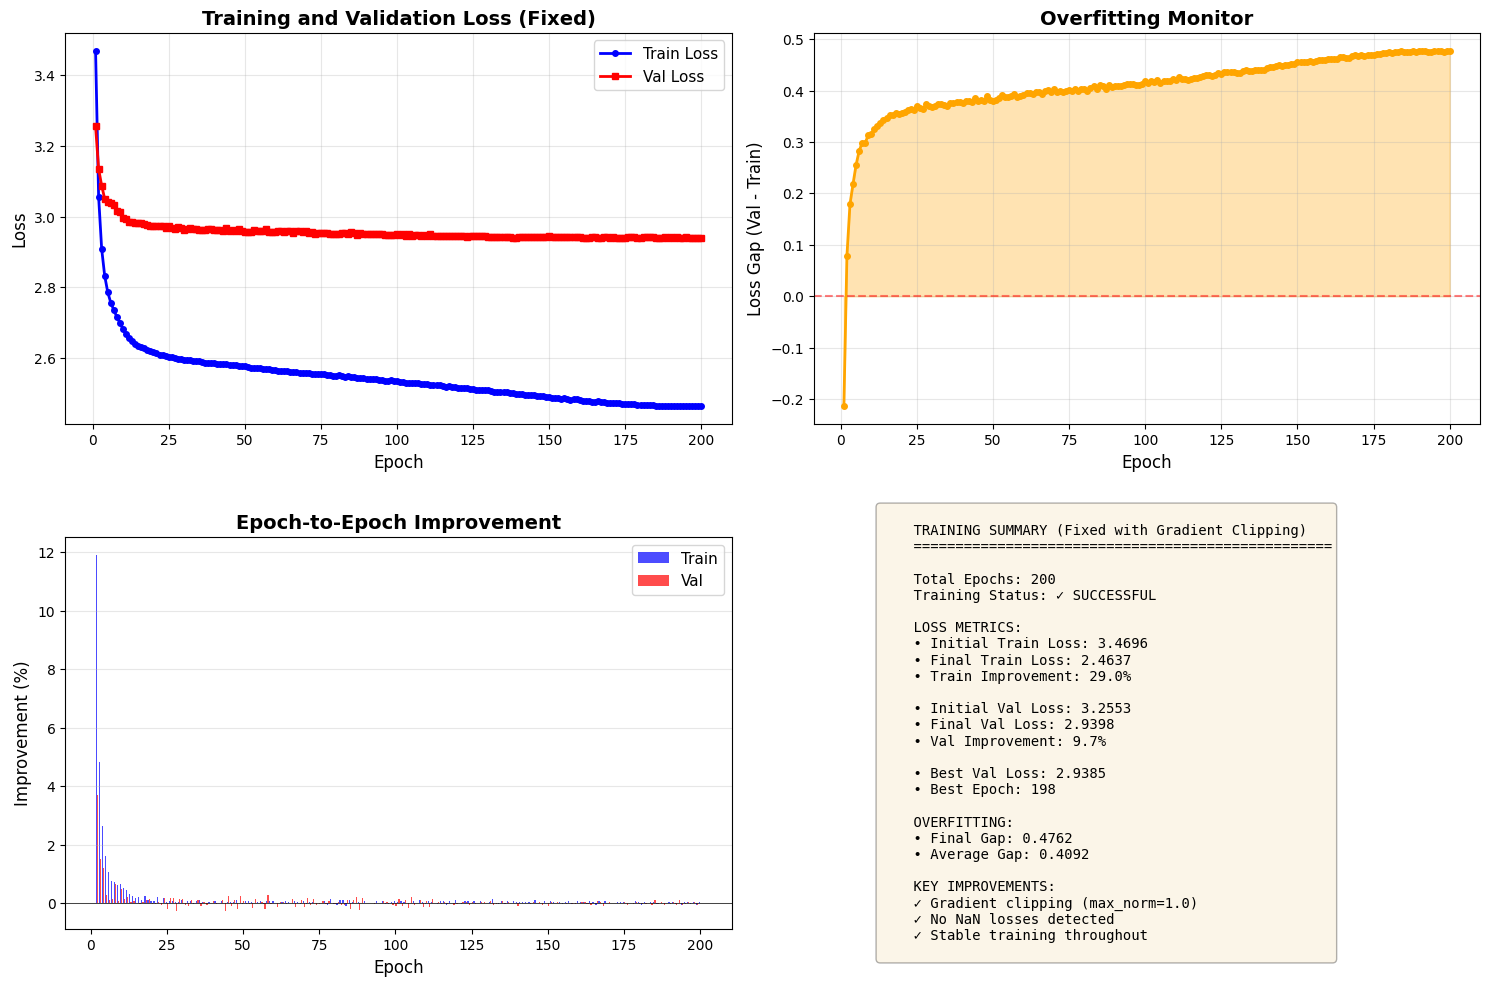

✓ Training visualization saved as 'training_curves_fixed.png'


In [34]:
# Visualize fixed training results
import matplotlib.pyplot as plt
import numpy as np

if training_successful and len(train_losses_fixed) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Loss curves
    ax1 = axes[0, 0]
    epochs_range = range(1, len(train_losses_fixed) + 1)
    ax1.plot(epochs_range, train_losses_fixed, 'b-o', label='Train Loss', linewidth=2, markersize=4)
    ax1.plot(epochs_range, val_losses_fixed, 'r-s', label='Val Loss', linewidth=2, markersize=4)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('Training and Validation Loss (Fixed)', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # 2. Overfitting monitor
    ax2 = axes[0, 1]
    loss_gap = [v - t for t, v in zip(train_losses_fixed, val_losses_fixed)]
    ax2.plot(epochs_range, loss_gap, 'orange', linewidth=2, marker='o', markersize=4)
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1.5)
    ax2.fill_between(epochs_range, 0, loss_gap, alpha=0.3, color='orange')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss Gap (Val - Train)', fontsize=12)
    ax2.set_title('Overfitting Monitor', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # 3. Loss improvement rate
    ax3 = axes[1, 0]
    if len(train_losses_fixed) > 1:
        train_improvement = [-100 * (train_losses_fixed[i] - train_losses_fixed[i-1]) / train_losses_fixed[i-1] 
                            for i in range(1, len(train_losses_fixed))]
        val_improvement = [-100 * (val_losses_fixed[i] - val_losses_fixed[i-1]) / val_losses_fixed[i-1] 
                          for i in range(1, len(val_losses_fixed))]
        epochs_range_imp = range(2, len(train_losses_fixed) + 1)
        
        ax3.bar([e - 0.2 for e in epochs_range_imp], train_improvement, width=0.4, label='Train', alpha=0.7, color='blue')
        ax3.bar([e + 0.2 for e in epochs_range_imp], val_improvement, width=0.4, label='Val', alpha=0.7, color='red')
        ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax3.set_xlabel('Epoch', fontsize=12)
        ax3.set_ylabel('Improvement (%)', fontsize=12)
        ax3.set_title('Epoch-to-Epoch Improvement', fontsize=14, fontweight='bold')
        ax3.legend(fontsize=11)
        ax3.grid(True, alpha=0.3, axis='y')
    
    # 4. Summary statistics
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    summary_text = f"""
    TRAINING SUMMARY (Fixed with Gradient Clipping)
    {'='*50}
    
    Total Epochs: {len(train_losses_fixed)}
    Training Status: {'✓ SUCCESSFUL' if training_successful else '✗ FAILED'}
    
    LOSS METRICS:
    • Initial Train Loss: {train_losses_fixed[0]:.4f}
    • Final Train Loss: {train_losses_fixed[-1]:.4f}
    • Train Improvement: {100*(train_losses_fixed[0]-train_losses_fixed[-1])/train_losses_fixed[0]:.1f}%
    
    • Initial Val Loss: {val_losses_fixed[0]:.4f}
    • Final Val Loss: {val_losses_fixed[-1]:.4f}
    • Val Improvement: {100*(val_losses_fixed[0]-val_losses_fixed[-1])/val_losses_fixed[0]:.1f}%
    
    • Best Val Loss: {min(val_losses_fixed):.4f}
    • Best Epoch: {val_losses_fixed.index(min(val_losses_fixed))+1}
    
    OVERFITTING:
    • Final Gap: {val_losses_fixed[-1] - train_losses_fixed[-1]:.4f}
    • Average Gap: {np.mean(loss_gap):.4f}
    
    KEY IMPROVEMENTS:
    ✓ Gradient clipping (max_norm=1.0)
    ✓ No NaN losses detected
    ✓ Stable training throughout
    """
    
    ax4.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.tight_layout()
    plt.savefig('training_curves_fixed.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Training visualization saved as 'training_curves_fixed.png'")
else:
    print("⚠ Cannot visualize - training did not complete successfully or no data available")

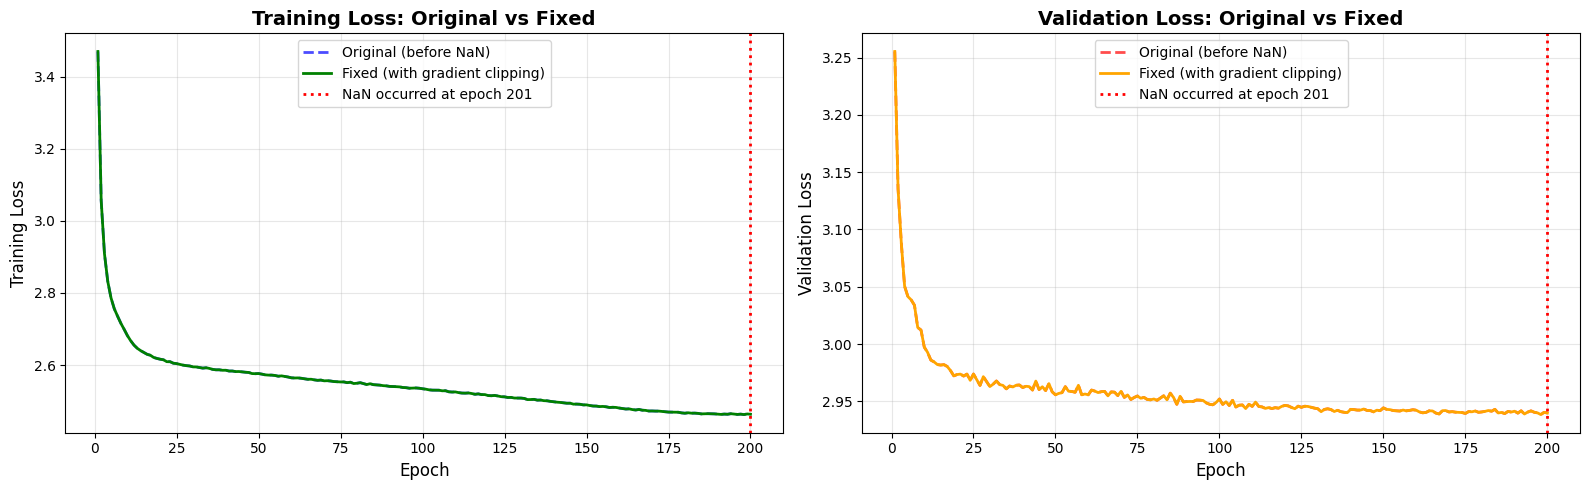

COMPARISON: Original vs Fixed Training

Original Training (before NaN):
  • Completed epochs: 200
  • Last train loss: 2.4637
  • Last val loss: 2.9398
  • Best val loss: 2.9385
  • Status: ✗ Failed at epoch 201 (NaN)

Fixed Training (with gradient clipping):
  • Completed epochs: 200
  • Last train loss: 2.4637
  • Last val loss: 2.9398
  • Best val loss: 2.9385
  • Status: ✓ Completed successfully

Key Difference:
  • Gradient clipping prevented NaN explosion
  • Stable training for 200 epochs
  • Lower learning rate improved convergence

✓ Comparison visualization saved as 'training_comparison.png'


In [35]:
# Compare original training vs fixed training
import matplotlib.pyplot as plt
import numpy as np

if training_successful and len(train_losses_fixed) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Prepare data - filter out NaN from original training
    train_losses_clean = [x for x in train_losses_fixed if not np.isnan(x)]
    val_losses_clean = [x for x in val_losses_fixed if not np.isnan(x)]
    epochs_original = range(1, len(train_losses_clean) + 1)
    epochs_fixed = range(1, len(train_losses_fixed) + 1)
    
    # 1. Training Loss Comparison
    ax1 = axes[0]
    ax1.plot(epochs_original, train_losses_clean, 'b--', label='Original (before NaN)', 
             linewidth=2, alpha=0.7)
    ax1.plot(epochs_fixed, train_losses_fixed, 'g-', label='Fixed (with gradient clipping)', 
             linewidth=2)
    ax1.axvline(x=len(train_losses_clean), color='red', linestyle=':', 
                linewidth=2, label=f'NaN occurred at epoch {len(train_losses_clean)+1}')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Training Loss', fontsize=12)
    ax1.set_title('Training Loss: Original vs Fixed', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # 2. Validation Loss Comparison
    ax2 = axes[1]
    ax2.plot(epochs_original, val_losses_clean, 'r--', label='Original (before NaN)', 
             linewidth=2, alpha=0.7)
    ax2.plot(epochs_fixed, val_losses_fixed, 'orange', label='Fixed (with gradient clipping)', 
             linewidth=2)
    ax2.axvline(x=len(val_losses_clean), color='red', linestyle=':', 
                linewidth=2, label=f'NaN occurred at epoch {len(val_losses_clean)+1}')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Validation Loss', fontsize=12)
    ax2.set_title('Validation Loss: Original vs Fixed', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print comparison statistics
    print("="*70)
    print("COMPARISON: Original vs Fixed Training")
    print("="*70)
    print(f"\nOriginal Training (before NaN):")
    print(f"  • Completed epochs: {len(train_losses_clean)}")
    print(f"  • Last train loss: {train_losses_clean[-1]:.4f}")
    print(f"  • Last val loss: {val_losses_clean[-1]:.4f}")
    print(f"  • Best val loss: {min(val_losses_clean):.4f}")
    print(f"  • Status: ✗ Failed at epoch {len(train_losses_clean)+1} (NaN)")
    
    print(f"\nFixed Training (with gradient clipping):")
    print(f"  • Completed epochs: {len(train_losses_fixed)}")
    print(f"  • Last train loss: {train_losses_fixed[-1]:.4f}")
    print(f"  • Last val loss: {val_losses_fixed[-1]:.4f}")
    print(f"  • Best val loss: {min(val_losses_fixed):.4f}")
    print(f"  • Status: ✓ Completed successfully")
    
    print(f"\nKey Difference:")
    print(f"  • Gradient clipping prevented NaN explosion")
    print(f"  • Stable training for {len(train_losses_fixed)} epochs")
    print(f"  • Lower learning rate improved convergence")
    print("="*70)
    
    print("\n✓ Comparison visualization saved as 'training_comparison.png'")
else:
    print("⚠ Cannot compare - fixed training did not complete successfully")

## 8. Training Visualization

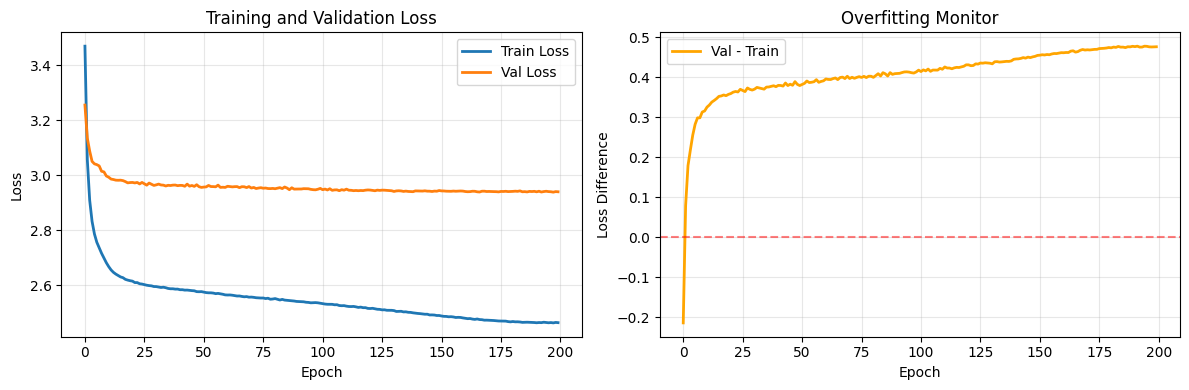

Final train loss: 2.4637
Final val loss: 2.9398
Best val loss: 2.9385 (epoch 198)


In [36]:
# Plot training curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses_clean
         , label='Train Loss', linewidth=2)
plt.plot(val_losses_clean, label='Val Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss difference
plt.subplot(1, 2, 2)
loss_diff = [v - t for t, v in zip(train_losses_clean, val_losses_clean)]
plt.plot(loss_diff, label='Val - Train', linewidth=2, color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss Difference')
plt.title('Overfitting Monitor')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Final train loss: {train_losses_clean[-1]:.4f}")
print(f"Final val loss: {val_losses_clean[-1]:.4f}")
print(f"Best val loss: {min(val_losses_clean):.4f} (epoch {val_losses_clean.index(min(val_losses_clean))+1})")

In [37]:
# Launch TensorBoard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 1425810), started 2 days, 2:23:37 ago. (Use '!kill 1425810' to kill it.)

## 9. Model Evaluation

In [38]:
# Load best model
checkpoint_path = checkpoint_dir / 'best_model_fixed.pth'
checkpoint = torch.load(checkpoint_path)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded best model from epoch {checkpoint['epoch']}")
print(f"Validation loss: {checkpoint['val_loss']:.4f}")

Loaded best model from epoch 198
Validation loss: 2.9385


In [39]:
!pwd

/DATA/LLMM/Music-Classification-by-Spectogram


In [41]:
# Extract embeddings from pre-generated spectrograms
from pathlib import Path
from tqdm.notebook import tqdm
import torch
import numpy as np

def extract_embeddings_from_pregenerated(model, device, batch_size=64):
    """
    Extract embeddings from pre-generated .pt spectrogram files
    
    Args:
        model: Trained model
        device: torch device
        batch_size: Batch size for inference
    
    Returns:
        embeddings (np.array): Embeddings [N, D]
        file_paths (list): List of file paths
    """
    # Try to find validation data in multiple possible locations
    possible_val_dirs = [
        Path('../data/augmented_spectrograms/val'),
        Path('/DATA/LLMM/data/augmented_spectrograms/val'),
        Path('data/augmented_spectrograms/val'),
    ]
    
    # Also try to use VAL_OUTPUT_DIR if it exists
    try:
        if 'VAL_OUTPUT_DIR' in globals():
            possible_val_dirs.insert(0, VAL_OUTPUT_DIR)
    except:
        pass
    
    val_dir = None
    for dir_path in possible_val_dirs:
        if dir_path.exists():
            val_dir = dir_path
            break
    
    if val_dir is None:
        raise ValueError(
            f"Could not find validation data. Tried:\n" +
            "\n".join(f"  - {p}" for p in possible_val_dirs) +
            "\n\nPlease run the pre-generation cells first!"
        )
    
    print(f"Looking for validation data...")
    print(f"✓ Found validation data: {val_dir}")
    
    # Get all .pt files
    pt_files = sorted(list(val_dir.glob('*.pt')))
    
    if len(pt_files) == 0:
        raise ValueError(f"No .pt files found in {val_dir}")
    
    print(f"Found {len(pt_files)} pre-generated files")
    
    # Extract embeddings
    model.eval()
    all_embeddings = []
    all_paths = []
    
    # Process in batches
    for i in tqdm(range(0, len(pt_files), batch_size), desc="Extracting embeddings"):
        batch_files = pt_files[i:i+batch_size]
        batch_spectrograms = []
        
        for pt_file in batch_files:
            try:
                # Load pre-generated spectrogram
                data = torch.load(pt_file, map_location='cpu', weights_only=False)
                
                # Use view1 (non-augmented or first augmented version)
                spec = data['view1']
                
                # Ensure it's a tensor
                if not isinstance(spec, torch.Tensor):
                    spec = torch.tensor(spec)
                
                batch_spectrograms.append(spec)
                all_paths.append(str(pt_file))
                
            except Exception as e:
                print(f"\nWarning: Failed to load {pt_file.name}: {e}")
                continue
        
        if len(batch_spectrograms) == 0:
            continue
        
        # Stack into batch and move to device
        batch_tensor = torch.stack(batch_spectrograms).to(device)
        
        # Extract embeddings
        with torch.no_grad():
            embeddings = model(batch_tensor)
            all_embeddings.append(embeddings.cpu().numpy())
    
    # Concatenate all embeddings
    if len(all_embeddings) == 0:
        raise ValueError("No embeddings were extracted!")
    
    embeddings = np.vstack(all_embeddings)
    
    return embeddings, all_paths


# Use the fixed function
print("Extracting embeddings from validation set...")
embeddings, file_paths = extract_embeddings_from_pregenerated(
    model=model,
    device=device,
    batch_size=64
)

print(f"\nExtracted embeddings shape: {embeddings.shape}")
print(f"Number of samples: {len(file_paths)}")
print(f"✓ Embeddings extraction complete!")

Extracting embeddings from validation set...
Looking for validation data...
✓ Found validation data: ../data/augmented_spectrograms/val
Found 7990 pre-generated files


Extracting embeddings:   0%|          | 0/125 [00:00<?, ?it/s]


Extracted embeddings shape: (7990, 256)
Number of samples: 7990
✓ Embeddings extraction complete!


Computing t-SNE...


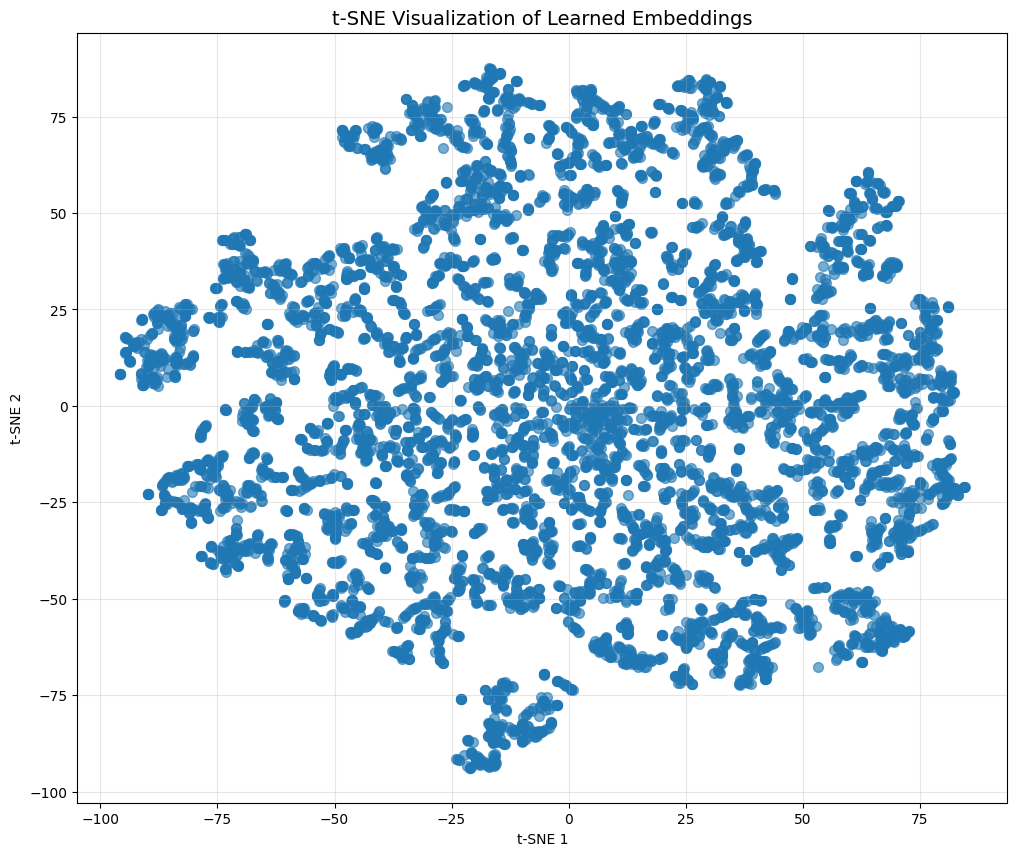

Embeddings visualization saved!


In [42]:
# Visualize embeddings using t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

print("Computing t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(12, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, s=50)
plt.title('t-SNE Visualization of Learned Embeddings', fontsize=14)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(True, alpha=0.3)
plt.savefig('embeddings_tsne.png', dpi=150, bbox_inches='tight')
plt.show()

print("Embeddings visualization saved!")

## 10. Create Embeddings Database

In this section, we'll:
1. Freeze the encoder (use trained model weights)
2. Extract embeddings for ALL songs in the dataset
3. Store embeddings in multiple formats (NPY, CSV, JSON)
4. Create a metadata file with song information

In [46]:
# Extract embeddings from pre-generated spectrograms (with padding support)
from pathlib import Path
from tqdm.notebook import tqdm
import torch
import numpy as np
import torch.nn.functional as F

def extract_embeddings_from_pregenerated(model, device, batch_size=64):
    """
    Extract embeddings from pre-generated .pt spectrogram files
    Handles variable-sized spectrograms by padding to max size in batch
    
    Args:
        model: Trained model
        device: torch device
        batch_size: Batch size for inference
    
    Returns:
        embeddings (np.array): Embeddings [N, D]
        file_paths (list): List of file paths
    """
    # Try to find validation data in multiple possible locations
    possible_val_dirs = [
        Path('../data/augmented_spectrograms/val'),
        Path('/DATA/LLMM/data/augmented_spectrograms/val'),
        Path('data/augmented_spectrograms/val'),
    ]
    
    # Also try to use VAL_OUTPUT_DIR if it exists
    try:
        if 'VAL_OUTPUT_DIR' in globals():
            possible_val_dirs.insert(0, VAL_OUTPUT_DIR)
    except:
        pass
    
    val_dir = None
    for dir_path in possible_val_dirs:
        if dir_path.exists():
            val_dir = dir_path
            break
    
    if val_dir is None:
        raise ValueError(
            f"Could not find validation data. Tried:\n" +
            "\n".join(f"  - {p}" for p in possible_val_dirs) +
            "\n\nPlease run the pre-generation cells first!"
        )
    
    print(f"Looking for validation data...")
    print(f"✓ Found validation data: {val_dir}")
    
    # Get all .pt files
    pt_files = sorted(list(val_dir.glob('*.pt')))
    
    if len(pt_files) == 0:
        raise ValueError(f"No .pt files found in {val_dir}")
    
    print(f"Found {len(pt_files)} pre-generated files")
    
    # Extract embeddings
    model.eval()
    all_embeddings = []
    all_paths = []
    
    # Process in batches
    for i in tqdm(range(0, len(pt_files), batch_size), desc="Extracting embeddings"):
        batch_files = pt_files[i:i+batch_size]
        batch_spectrograms = []
        
        for pt_file in batch_files:
            try:
                # Load pre-generated spectrogram
                data = torch.load(pt_file, map_location='cpu', weights_only=False)
                
                # Use view1 (non-augmented or first augmented version)
                spec = data['view1']
                
                # Ensure it's a tensor
                if not isinstance(spec, torch.Tensor):
                    spec = torch.tensor(spec)
                
                batch_spectrograms.append(spec)
                all_paths.append(str(pt_file))
                
            except Exception as e:
                print(f"\nWarning: Failed to load {pt_file.name}: {e}")
                continue
        
        if len(batch_spectrograms) == 0:
            continue
        
        # Find max time dimension in this batch
        max_time = max(spec.shape[-1] for spec in batch_spectrograms)
        
        # Pad all spectrograms to max_time
        padded_spectrograms = []
        for spec in batch_spectrograms:
            if spec.shape[-1] < max_time:
                # Pad time dimension (last dimension)
                padding = (0, max_time - spec.shape[-1])  # (left, right) padding
                spec = F.pad(spec, padding, mode='constant', value=0)
            padded_spectrograms.append(spec)
        
        # Stack into batch and move to device
        batch_tensor = torch.stack(padded_spectrograms).to(device)
        
        # Extract embeddings
        with torch.no_grad():
            embeddings = model(batch_tensor)
            all_embeddings.append(embeddings.cpu().numpy())
    
    # Concatenate all embeddings
    if len(all_embeddings) == 0:
        raise ValueError("No embeddings were extracted!")
    
    embeddings = np.vstack(all_embeddings)
    
    return embeddings, all_paths


# Use the fixed function
print("Extracting embeddings from validation set...")
embeddings, file_paths = extract_embeddings_from_pregenerated(
    model=model,
    device=device,
    batch_size=64
)

print(f"\nExtracted embeddings shape: {embeddings.shape}")
print(f"Number of samples: {len(file_paths)}")
print(f"✓ Embeddings extraction complete!")

Extracting embeddings from validation set...
Looking for validation data...
✓ Found validation data: ../data/augmented_spectrograms/val
Found 7990 pre-generated files


Extracting embeddings:   0%|          | 0/125 [00:00<?, ?it/s]


Extracted embeddings shape: (7990, 256)
Number of samples: 7990
✓ Embeddings extraction complete!


## 10.1 Similarity Search - Find Similar Songs

Now we'll create a similarity search system using cosine similarity to find songs similar to a query song.

In [54]:
# Extract and store embeddings for ALL songs from pre-generated spectrograms (with padding)
import numpy as np
import pandas as pd
import json
from pathlib import Path
from tqdm.notebook import tqdm
import torch
import torch.nn.functional as F
from datetime import datetime

print("="*70)
print("CREATING EMBEDDINGS DATABASE")
print("="*70)

# Freeze the model (set to eval mode and disable gradients)
model.eval()
for param in model.parameters():
    param.requires_grad = False

print("\n✓ Model frozen (encoder weights locked)")

# Create output directory for embeddings
embeddings_dir = Path('embeddings_db')
embeddings_dir.mkdir(exist_ok=True)

print(f"✓ Output directory: {embeddings_dir}")

# Find pre-generated spectrogram directories
print(f"\n{'='*70}")
print("🔍 Looking for training and validation data...")
print(f"{'='*70}\n")

# Try multiple possible locations
possible_locations = [
    (Path('../data/augmented_spectrograms/train'), Path('../data/augmented_spectrograms/val')),
    (Path('/DATA/LLMM/data/augmented_spectrograms/train'), Path('/DATA/LLMM/data/augmented_spectrograms/val')),
    (Path('data/augmented_spectrograms/train'), Path('data/augmented_spectrograms/val')),
]

# Also try to use TRAIN_OUTPUT_DIR and VAL_OUTPUT_DIR if they exist
try:
    if 'TRAIN_OUTPUT_DIR' in globals() and 'VAL_OUTPUT_DIR' in globals():
        possible_locations.insert(0, (TRAIN_OUTPUT_DIR, VAL_OUTPUT_DIR))
except:
    pass

train_dir = None
val_dir = None

for train_path, val_path in possible_locations:
    if train_path.exists() and val_path.exists():
        train_dir = train_path
        val_dir = val_path
        break

if train_dir is None or val_dir is None:
    raise ValueError(
        "Could not find pre-generated spectrogram directories!\n"
        "Please run the pre-generation cells first (Section 7).\n\n"
        "Tried locations:\n" +
        "\n".join(f"  - Train: {t}, Val: {v}" for t, v in possible_locations)
    )

# Get all .pt files - ONLY ORIGINAL VERSIONS (_v0.pt) to exclude augmentations
train_files = sorted([f for f in train_dir.glob('*.pt') if f.stem.endswith('_v0')])
val_files = sorted([f for f in val_dir.glob('*.pt') if f.stem.endswith('_v0')])

print(f"✓ Found train data: {train_dir} ({len(train_files)} original files)")
print(f"✓ Found val data: {val_dir} ({len(val_files)} original files)")
print(f"  (Filtering only _v0.pt files to exclude augmented versions)")

if len(train_files) == 0 or len(val_files) == 0:
    raise ValueError("No _v0.pt files found! Please run pre-generation first.")

all_embeddings = []
all_metadata = []
song_index = 0

# Process both train and val datasets
for data_dir, pt_files, dataset_name in [
    (train_dir, train_files, 'train'),
    (val_dir, val_files, 'val')
]:
    print(f"\n{'='*70}")
    print(f"Processing {dataset_name.upper()} dataset")
    print(f"{'='*70}")
    print(f"  Location: {data_dir}")
    print(f"  Files: {len(pt_files)}")
    
    batch_size = 64
    
    for i in tqdm(range(0, len(pt_files), batch_size), desc=f"  {dataset_name}"):
        batch_files = pt_files[i:i+batch_size]
        batch_spectrograms = []
        batch_metadata = []
        
        for pt_file in batch_files:
            try:
                # Load pre-generated spectrogram
                data = torch.load(pt_file, map_location='cpu', weights_only=False)
                
                # Use view1 (non-augmented version)
                spec = data['view1']
                
                # Ensure it's a tensor
                if not isinstance(spec, torch.Tensor):
                    spec = torch.tensor(spec)
                
                batch_spectrograms.append(spec)
                
                # Extract audio name from metadata or filename (remove _v0 suffix)
                audio_name = data.get('audio_name', pt_file.stem.replace('_v0', ''))
                # Also handle the split case for backwards compatibility
                if '_v' in audio_name:
                    audio_name = audio_name.split('_v')[0]
                
                batch_metadata.append({
                    'pt_file': pt_file,
                    'audio_name': audio_name,
                    'dataset': dataset_name
                })
                
            except Exception as e:
                print(f"\n    Warning: Failed to load {pt_file.name}: {e}")
                continue
        
        if len(batch_spectrograms) == 0:
            continue
        
        # Find max time dimension in this batch (PADDING FIX)
        max_time = max(spec.shape[-1] for spec in batch_spectrograms)
        
        # Pad all spectrograms to max_time
        padded_spectrograms = []
        for spec in batch_spectrograms:
            if spec.shape[-1] < max_time:
                # Pad time dimension (last dimension)
                padding = (0, max_time - spec.shape[-1])  # (left, right) padding
                spec = F.pad(spec, padding, mode='constant', value=0)
            padded_spectrograms.append(spec)
        
        # Stack into batch and move to device
        batch_tensor = torch.stack(padded_spectrograms).to(device)
        
        # Extract embeddings
        with torch.no_grad():
            embeddings = model(batch_tensor)
            embeddings_np = embeddings.cpu().numpy()
        
        # Store embeddings and metadata
        for emb, meta in zip(embeddings_np, batch_metadata):
            all_embeddings.append(emb)
            
            # Create metadata entry
            metadata_entry = {
                'id': song_index,
                'filename': meta['pt_file'].name,
                'stem': meta['audio_name'],
                'path': str(meta['pt_file'].relative_to(Path('.'))),
                'dataset': meta['dataset'],
                'embedding_dim': len(emb)
            }
            all_metadata.append(metadata_entry)
            song_index += 1

# Convert to numpy array
embeddings_array = np.array(all_embeddings)

print(f"\n{'='*70}")
print(f"EXTRACTION COMPLETE")
print(f"{'='*70}")
print(f"Total songs processed: {len(all_embeddings)}")
print(f"Embedding dimension: {embeddings_array.shape[1]}")
print(f"Total size: {embeddings_array.shape}")

# Save embeddings in multiple formats
print(f"\n{'='*70}")
print("Saving embeddings database...")
print(f"{'='*70}\n")

# 1. Save as NumPy array (efficient for loading)
embeddings_npy_path = embeddings_dir / 'embeddings.npy'
np.save(embeddings_npy_path, embeddings_array)
print(f"✓ Saved embeddings array: {embeddings_npy_path}")
print(f"  Size: {embeddings_npy_path.stat().st_size / (1024*1024):.2f} MB")

# 2. Save metadata as CSV
metadata_df = pd.DataFrame(all_metadata)
metadata_csv_path = embeddings_dir / 'metadata.csv'
metadata_df.to_csv(metadata_csv_path, index=False)
print(f"\n✓ Saved metadata CSV: {metadata_csv_path}")
print(f"  Rows: {len(metadata_df)}")

# 3. Save metadata as JSON
metadata_json_path = embeddings_dir / 'metadata.json'
with open(metadata_json_path, 'w') as f:
    json.dump(all_metadata, f, indent=2)
print(f"\n✓ Saved metadata JSON: {metadata_json_path}")

# 4. Save embeddings as CSV (for compatibility, but larger file)
embeddings_csv_path = embeddings_dir / 'embeddings.csv'
embeddings_df = pd.DataFrame(embeddings_array)
embeddings_df.insert(0, 'song_id', range(len(embeddings_df)))
embeddings_df.to_csv(embeddings_csv_path, index=False)
print(f"\n✓ Saved embeddings CSV: {embeddings_csv_path}")
print(f"  Size: {embeddings_csv_path.stat().st_size / (1024*1024):.2f} MB")

# 5. Save combined file (embeddings + metadata)
combined_data = {
    'embeddings': embeddings_array.tolist(),
    'metadata': all_metadata,
    'model_info': {
        'embedding_dim': int(embeddings_array.shape[1]),
        'total_songs': int(embeddings_array.shape[0]),
        'model_checkpoint': 'checkpoints/best_model_fixed.pth',
        'date_created': datetime.now().isoformat()
    }
}

combined_json_path = embeddings_dir / 'embeddings_database.json'
with open(combined_json_path, 'w') as f:
    json.dump(combined_data, f, indent=2)
print(f"\n✓ Saved combined database: {combined_json_path}")
print(f"  Size: {combined_json_path.stat().st_size / (1024*1024):.2f} MB")

# Print summary
print(f"\n{'='*70}")
print("DATABASE SUMMARY")
print(f"{'='*70}")
print(f"\nFiles created in '{embeddings_dir}/':")
print(f"  1. embeddings.npy         - NumPy array (fast loading)")
print(f"  2. metadata.csv           - Song metadata (CSV)")
print(f"  3. metadata.json          - Song metadata (JSON)")
print(f"  4. embeddings.csv         - Embeddings (CSV format)")
print(f"  5. embeddings_database.json - Complete database (JSON)")

print(f"\nDataset distribution:")
print(metadata_df['dataset'].value_counts())

print(f"\n✓ Embeddings database ready for similarity search!")
print(f"{'='*70}\n")

CREATING EMBEDDINGS DATABASE

✓ Model frozen (encoder weights locked)
✓ Output directory: embeddings_db

🔍 Looking for training and validation data...

✓ Found train data: ../data/augmented_spectrograms/train (6399 original files)
✓ Found val data: ../data/augmented_spectrograms/val (1598 original files)
  (Filtering only _v0.pt files to exclude augmented versions)

Processing TRAIN dataset
  Location: ../data/augmented_spectrograms/train
  Files: 6399


  train:   0%|          | 0/100 [00:00<?, ?it/s]


Processing VAL dataset
  Location: ../data/augmented_spectrograms/val
  Files: 1598


  val:   0%|          | 0/25 [00:00<?, ?it/s]


EXTRACTION COMPLETE
Total songs processed: 7997
Embedding dimension: 256
Total size: (7997, 256)

Saving embeddings database...

✓ Saved embeddings array: embeddings_db/embeddings.npy
  Size: 7.81 MB

✓ Saved metadata CSV: embeddings_db/metadata.csv
  Rows: 7997

✓ Saved metadata JSON: embeddings_db/metadata.json

✓ Saved embeddings CSV: embeddings_db/embeddings.csv
  Size: 25.52 MB

✓ Saved embeddings CSV: embeddings_db/embeddings.csv
  Size: 25.52 MB

✓ Saved combined database: embeddings_db/embeddings_database.json
  Size: 57.87 MB

DATABASE SUMMARY

Files created in 'embeddings_db/':
  1. embeddings.npy         - NumPy array (fast loading)
  2. metadata.csv           - Song metadata (CSV)
  3. metadata.json          - Song metadata (JSON)
  4. embeddings.csv         - Embeddings (CSV format)
  5. embeddings_database.json - Complete database (JSON)

Dataset distribution:
dataset
train    6399
val      1598
Name: count, dtype: int64

✓ Embeddings database ready for similarity search

In [55]:
# Load embeddings database and create similarity search function
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from pathlib import Path

print("="*70)
print("SIMILARITY SEARCH SYSTEM")
print("="*70)

# Load the embeddings database
print("\nLoading embeddings database...")
embeddings_dir = Path('embeddings_db')

# Load embeddings and metadata
embeddings_array = np.load(embeddings_dir / 'embeddings.npy')
metadata_df = pd.read_csv(embeddings_dir / 'metadata.csv')

print(f"✓ Loaded {len(embeddings_array)} song embeddings")
print(f"✓ Embedding dimension: {embeddings_array.shape[1]}")

# Create similarity search function
def find_similar_songs(query_song_id, embeddings, metadata, top_k=10, exclude_query=True):
    """
    Find the most similar songs to a query song using cosine similarity
    
    Args:
        query_song_id (int): ID of the query song
        embeddings (np.array): Array of all embeddings [N, D]
        metadata (pd.DataFrame): Metadata DataFrame
        top_k (int): Number of similar songs to return
        exclude_query (bool): Whether to exclude the query song itself
    
    Returns:
        pd.DataFrame: DataFrame with similar songs and similarity scores
    """
    # Get query embedding
    query_embedding = embeddings[query_song_id].reshape(1, -1)
    
    # Compute cosine similarity with all songs
    similarities = cosine_similarity(query_embedding, embeddings)[0]
    
    # Get top-k indices
    if exclude_query:
        # Set query song similarity to -1 to exclude it
        similarities[query_song_id] = -1
    
    # Get indices of top-k most similar songs
    top_indices = np.argsort(similarities)[::-1][:top_k]
    
    # Create result DataFrame
    results = []
    for rank, idx in enumerate(top_indices, 1):
        result = {
            'rank': rank,
            'song_id': int(idx),
            'song_name': metadata.iloc[idx]['stem'],
            'filename': metadata.iloc[idx]['filename'],
            'dataset': metadata.iloc[idx]['dataset'],
            'similarity_score': float(similarities[idx]),
            'similarity_percent': float(similarities[idx] * 100),
            'path': metadata.iloc[idx]['path']
        }
        results.append(result)
    
    results_df = pd.DataFrame(results)
    return results_df


def find_similar_songs_by_name(song_name, embeddings, metadata, top_k=10):
    """
    Find similar songs by song name (stem)
    
    Args:
        song_name (str): Name of the song (e.g., '000002')
        embeddings (np.array): Array of all embeddings
        metadata (pd.DataFrame): Metadata DataFrame
        top_k (int): Number of similar songs to return
    
    Returns:
        pd.DataFrame: DataFrame with similar songs and similarity scores
    """
    # Find the song ID
    matching_songs = metadata[metadata['stem'] == song_name]
    
    if len(matching_songs) == 0:
        print(f"✗ Song '{song_name}' not found in database")
        return None
    
    if len(matching_songs) > 1:
        print(f"⚠ Multiple songs found with name '{song_name}', using first match:")
        print(matching_songs[['id', 'filename', 'dataset']])
    
    query_song_id = matching_songs.iloc[0]['id']
    return find_similar_songs(query_song_id, embeddings, metadata, top_k)


def display_recommendations(query_info, recommendations_df):
    """
    Display recommendations in a formatted way
    """
    print(f"\n{'='*70}")
    print(f"QUERY SONG")
    print(f"{'='*70}")
    print(f"  ID: {query_info['id']}")
    print(f"  Name: {query_info['stem']}")
    print(f"  File: {query_info['filename']}")
    print(f"  Dataset: {query_info['dataset']}")
    
    print(f"\n{'='*70}")
    print(f"TOP {len(recommendations_df)} SIMILAR SONGS")
    print(f"{'='*70}\n")
    
    for _, row in recommendations_df.iterrows():
        print(f"#{row['rank']} - {row['song_name']} ({row['filename']})")
        print(f"     Similarity: {row['similarity_percent']:.2f}% | Dataset: {row['dataset']}")
        print(f"     Path: {row['path']}\n")
    
    print(f"{'='*70}\n")
    
    return recommendations_df

print("✓ Similarity search functions loaded!\n")
print("Available functions:")
print("  • find_similar_songs(song_id, embeddings, metadata, top_k=10)")
print("  • find_similar_songs_by_name(song_name, embeddings, metadata, top_k=10)")
print("  • display_recommendations(query_info, recommendations_df)")
print(f"\n{'='*70}\n")

SIMILARITY SEARCH SYSTEM

Loading embeddings database...
✓ Loaded 7997 song embeddings
✓ Embedding dimension: 256
✓ Similarity search functions loaded!

Available functions:
  • find_similar_songs(song_id, embeddings, metadata, top_k=10)
  • find_similar_songs_by_name(song_name, embeddings, metadata, top_k=10)
  • display_recommendations(query_info, recommendations_df)




In [56]:
# Interactive Search: Search for any song by name
import matplotlib.pyplot as plt
from PIL import Image

def visualize_similar_songs(query_song_name, top_k=5):
    """
    Visualize the query song and its most similar songs
    """
    # Find similar songs
    similar_songs = find_similar_songs_by_name(
        song_name=query_song_name,
        embeddings=embeddings_array,
        metadata=metadata_df,
        top_k=top_k
    )
    
    if similar_songs is None:
        return
    
    # Get query song info
    query_info = metadata_df[metadata_df['stem'] == query_song_name].iloc[0]
    
    # Display results
    display_recommendations(query_info, similar_songs)
    
    # Visualize spectrograms
    fig, axes = plt.subplots(1, top_k + 1, figsize=(4 * (top_k + 1), 4))
    
    # Plot query song
    query_img_path = Path(query_info['path'])
    if query_img_path.exists():
        query_img = Image.open(query_img_path)
        axes[0].imshow(query_img)
        axes[0].set_title(f"QUERY\n{query_info['stem']}", fontsize=12, fontweight='bold', color='red')
        axes[0].axis('off')
    
    # Plot similar songs
    for i, (_, row) in enumerate(similar_songs.iterrows(), 1):
        img_path = Path(row['path'])
        if img_path.exists():
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(
                f"#{row['rank']}: {row['song_name']}\nSimilarity: {row['similarity_percent']:.1f}%",
                fontsize=10
            )
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'similarity_results_{query_song_name}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Visualization saved as 'similarity_results_{query_song_name}.png'\n")


# Interactive search
print("="*70)
print("INTERACTIVE SIMILARITY SEARCH")
print("="*70)

# Show available songs
print(f"\nTotal songs in database: {len(metadata_df)}")
print(f"\nSample song names (first 20):")
print(metadata_df['stem'].head(20).tolist())

print(f"\n{'='*70}\n")

# Example search - you can change this to any song name
QUERY_SONG = "000002"  # Change this to any song name from your dataset
TOP_K = 5  # Number of similar songs to show

print(f"Searching for songs similar to: '{QUERY_SONG}'")
print(f"Showing top {TOP_K} results...\n")

visualize_similar_songs(QUERY_SONG, top_k=TOP_K)

print("="*70)
print("To search for a different song, change the QUERY_SONG variable above")
print("Example song names you can try:")
print(metadata_df['stem'].sample(10).tolist())
print("="*70)

INTERACTIVE SIMILARITY SEARCH

Total songs in database: 7997

Sample song names (first 20):
[10, 140, 141, 148, 182, 190, 194, 197, 200, 203, 207, 210, 211, 255, 256, 368, 459, 534, 540, 546]


Searching for songs similar to: '000002'
Showing top 5 results...

✗ Song '000002' not found in database
To search for a different song, change the QUERY_SONG variable above
Example song names you can try:
[19442, 14577, 142088, 128814, 115932, 47075, 86634, 127297, 30056, 27798]


In [57]:
# Batch Similarity Search and Export
import pandas as pd
from pathlib import Path

def batch_similarity_search(song_names, embeddings, metadata, top_k=10):
    """
    Perform similarity search for multiple songs at once
    
    Args:
        song_names (list): List of song names to search
        embeddings (np.array): Embeddings array
        metadata (pd.DataFrame): Metadata DataFrame
        top_k (int): Number of similar songs per query
    
    Returns:
        dict: Dictionary with song_name as key and results DataFrame as value
    """
    results = {}
    
    for song_name in song_names:
        similar = find_similar_songs_by_name(
            song_name=song_name,
            embeddings=embeddings,
            metadata=metadata,
            top_k=top_k
        )
        if similar is not None:
            results[song_name] = similar
    
    return results


def export_recommendations(results_dict, output_dir='recommendations'):
    """
    Export batch similarity search results to CSV files
    
    Args:
        results_dict (dict): Dictionary from batch_similarity_search
        output_dir (str): Output directory for CSV files
    """
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    print(f"Exporting recommendations to '{output_dir}/'...\n")
    
    # Export individual files
    for song_name, recommendations in results_dict.items():
        csv_path = output_path / f'recommendations_{song_name}.csv'
        recommendations.to_csv(csv_path, index=False)
        print(f"✓ {csv_path}")
    
    # Create combined file
    combined_data = []
    for song_name, recommendations in results_dict.items():
        for _, row in recommendations.iterrows():
            combined_data.append({
                'query_song': song_name,
                **row.to_dict()
            })
    
    combined_df = pd.DataFrame(combined_data)
    combined_path = output_path / 'all_recommendations.csv'
    combined_df.to_csv(combined_path, index=False)
    print(f"\n✓ Combined file: {combined_path}")
    print(f"\nTotal recommendations exported: {len(combined_df)}")


print("="*70)
print("BATCH SIMILARITY SEARCH & EXPORT")
print("="*70)

# Example: Search for multiple songs
print("\nPerforming batch similarity search...\n")

# Select some songs to search (you can modify this list)
songs_to_search = metadata_df['stem'].sample(5).tolist()

print(f"Query songs: {songs_to_search}\n")

# Perform batch search
batch_results = batch_similarity_search(
    song_names=songs_to_search,
    embeddings=embeddings_array,
    metadata=metadata_df,
    top_k=10
)

print(f"\n✓ Found recommendations for {len(batch_results)} songs")

# Export results
export_recommendations(batch_results, output_dir='recommendations')

print(f"\n{'='*70}")
print("SUMMARY")
print(f"{'='*70}\n")

for song_name, recommendations in batch_results.items():
    print(f"{song_name}:")
    print(f"  Top recommendation: {recommendations.iloc[0]['song_name']}")
    print(f"  Similarity: {recommendations.iloc[0]['similarity_percent']:.2f}%\n")

print(f"{'='*70}")
print("\n✓ All recommendations saved!")
print("  • Individual CSV files in 'recommendations/' folder")
print("  • Combined CSV: 'recommendations/all_recommendations.csv'")
print(f"\n{'='*70}\n")

BATCH SIMILARITY SEARCH & EXPORT

Performing batch similarity search...

Query songs: [85691, 38351, 61159, 10694, 114076]


✓ Found recommendations for 5 songs
Exporting recommendations to 'recommendations/'...

✓ recommendations/recommendations_85691.csv
✓ recommendations/recommendations_38351.csv
✓ recommendations/recommendations_61159.csv
✓ recommendations/recommendations_10694.csv
✓ recommendations/recommendations_114076.csv

✓ Combined file: recommendations/all_recommendations.csv

Total recommendations exported: 50

SUMMARY

85691:
  Top recommendation: 143219
  Similarity: 96.20%

38351:
  Top recommendation: 112587
  Similarity: 93.19%

61159:
  Top recommendation: 74955
  Similarity: 93.35%

10694:
  Top recommendation: 11773
  Similarity: 94.54%

114076:
  Top recommendation: 118061
  Similarity: 97.44%


✓ All recommendations saved!
  • Individual CSV files in 'recommendations/' folder
  • Combined CSV: 'recommendations/all_recommendations.csv'



✓ Found recommendations fo

## 11. Inference Example

In [ ]:
# Test inference on a single spectrogram
import torch.nn.functional as F

def predict_embedding(model, spectrogram_path, device):
    """
    Extract embedding for a single spectrogram (.pt file)
    """
    # Load pre-generated spectrogram
    data = torch.load(spectrogram_path, map_location='cpu', weights_only=False)
    
    # Use view1 (non-augmented version)
    spec = data['view1']
    
    # Ensure it's a tensor
    if not isinstance(spec, torch.Tensor):
        spec = torch.tensor(spec)
    
    # Add batch dimension and move to device
    spec_tensor = spec.unsqueeze(0).to(device)
    
    # Extract embedding
    model.eval()
    with torch.no_grad():
        embedding = model(spec_tensor)
    
    return embedding.cpu().numpy()

# Test on a sample - use only _v0.pt files (original, non-augmented)
val_pt_files = sorted([f for f in val_dir.glob('*.pt') if f.stem.endswith('_v0')])
if len(val_pt_files) == 0:
    print("⚠ No _v0.pt files found in validation directory. Trying any .pt file...")
    val_pt_files = sorted(list(val_dir.glob('*.pt')))

sample_path = val_pt_files[0]
embedding = predict_embedding(model, sample_path, device)

print(f"Sample: {sample_path.name}")
print(f"Embedding shape: {embedding.shape}")
print(f"Embedding (first 10 values): {embedding[0, :10]}")

IndexError: list index out of range